# Testing out the Autotrail-TrailMap algorithm in a few test cases

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplleaflet
import geopandas as geopd
import srtm
import gpxpy
import networkx as nx
import os
import shapely



from matplotlib import rc, cm
viridis = cm.get_cmap('viridis')
magma   = cm.get_cmap('magma')
plasma  = cm.get_cmap('plasma')

from planit.autotrail import process_gpx_data as gpx_process
from planit.autotrail import maptrails
from planit.osm_data import osm_process

m_in_mi = 1609.34
m_in_ft = 0.3048

### Loading the Processed Dataset 
(this takes about ~5 minutes to regenerate if tweaked in the future)

In [4]:
#
# load the pickled traip map
#
#outname = './data/boulder_area_trail_processed'
#new_df, nodes, edges = gpx_process.load_trail_df(outname)
#tmap             = gpx_process.load_graph(outname)
#tmap.ensure_edge_attributes()

north = 40.100141
west  = -105.408908
south = 39.841447
east  = -105.163064
ll = (south,west)
rr = (north,east)

tmap = osm_process.osmnx_trailmap(ll=ll,rr=rr)
tmap.ensure_edge_attributes() 

#
# Set manually here for testing
#
tmap._default_weight_factors = {'distance'         : 1,
                                'elevation_gain'   : 1,
                                'elevation_loss'   : 0,      # off
                                'min_grade'        : 0,           # off
                                'max_grade'        : 0,           # off
                                'traversed_count'  : 10,    # very on
                                'in_another_route' : 2}    # medium on

Trying to find file:  /home/aemerick/code/planit/autotrail/40.10014_39.84145_-105.16306_-105.40891_osmnx_graph.pickle
cannot find file:  /home/aemerick/code/planit/autotrail/40.10014_39.84145_-105.16306_-105.40891_osmnx_graph.pickle


(-105.3045, -105.2545)


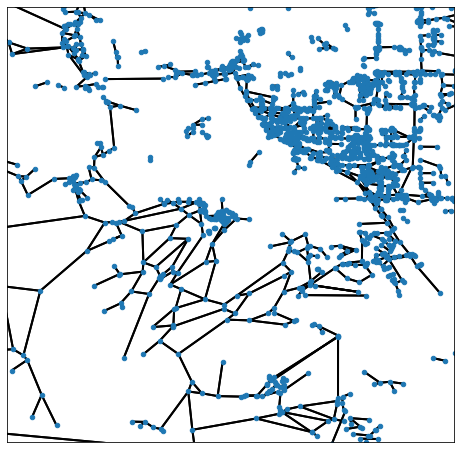

In [46]:
import networkx
def plot(graph, node_order=None, boring=False):
    #pos = nx.spring_layout(graph, weight='distance', seed = 12345)
    pos = {n : (d['x'],d['y']) for (n,d) in graph.nodes(data=True)}
    ax = nx.draw_networkx_nodes(graph, pos, node_size=20)

    ax.figure.set_size_inches(8,8)

    etraveled = [(u,v) for (u,v,d) in graph.edges(data=True)]
    #enottraveled = [(u,v) for (u,v,d) in graph.edges(data=True) if d['traversed_count'] == 0]

    colors = 'black'
    
    if (not (node_order is None)) and (not boring):
        ecolor_int = [node_order.index(e[0]) for e in etraveled]
        colors = magma((np.array(ecolor_int)+5) / ((1.0*len(node_order)+5)))
        
    if boring:
        style1 = style2 = 'solid'
        width1 = width2 = 3
    else:
        width1 = 6
        width2 = 2
        style1 = 'solid'
        style2 = 'dashed'
        
    temp = nx.draw_networkx_edges(graph, pos, edgelist=etraveled,width = 2, arrows=False,
                                  style='solid')
    #temp = nx.draw_networkx_edges(graph, pos, edgelist=enottraveled, width=width2, style=style2)
    
    #edge_labels = { (u,v) : "%i"%(d['distance']) for (u,v,d) in graph.edges(data=True)}
    #temp = nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, label_pos=0.5)
    
    #temp = nx.draw_networkx_labels(graph, pos, labels={n:n for n in graph.nodes()}, font_size=17,
    #                        font_color = 'white')


    return ax
print(ax.figure.axes[0].get_xlim())

chataqua = (-105.2795, 39.9972)
sep = 0.025
ax = plot(tmap,boring=True)
ax.figure.axes[0].set_xlim(chataqua[0] - sep, chataqua[0]+sep)
ax.figure.axes[0].set_ylim(chataqua[1] - sep, chataqua[1]+sep)

ax.figure.savefig('node_example.png')

# Test Case 1:

This is to sanity check some of the non-algorithm routines. Computes the shortest path between two known-to-be-connected does using the NX algorithm and plots results

Distance (mi)  Elev. + (ft)  Elev. - (ft) Min Elev. (ft) Max Elev. (ft) Min Grade (%) Max Grade (%)  Repeated (%)
         2.16           402           114          5643          6955         -0.00          0.00          0.00


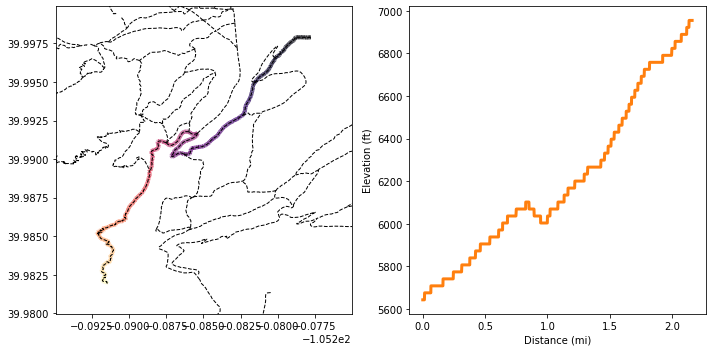

In [3]:
test_nodes = nx.shortest_path(tmap, 1041, 1762)
test_edges = tmap.edges_from_nodes(test_nodes)

#route_line = tmap.reduce_edge_data('geometry', 
#                          edges = test_edges,
#                          function = gpx_process.combine_gpx)

route_totals = tmap.route_properties(edges=test_edges)

fig, ax = maptrails.plot_trails(tmap, edges=test_edges, show_profile=True, fs = 5)

In [27]:
route_line = tmap.get_route_coords(edges=test_edges)

In [28]:
temp = [c for c in route_line.coords]
x = json.dumps([temp, temp])
y = json.loads(x)

[-105.27776961326293, 39.9978972217264, 1722.0]

## Test Case 1.1:

Using the above, now compute an algorithmified version of the same route. Try for a few distance constraints

Distance (mi)  Elev. + (ft)  Elev. - (ft) Min Elev. (ft) Max Elev. (ft) Min Grade (%) Max Grade (%)  Repeated (%)
         3.22           918           481          5643          6955        -32.61          0.00          0.00


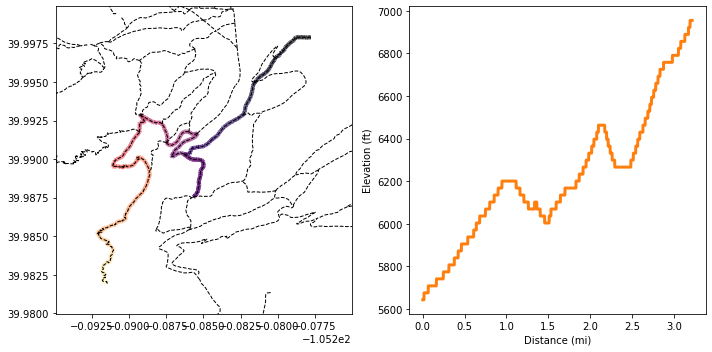

In [4]:
dist          =   3.0 * m_in_mi
# elev          = 3000.0 * m_in_ft

target_values = {'distance' : dist}


totals, test_nodes = tmap.find_route(1041, 
                               target_values, 
                               end_node=1762, reinitialize=True, reset_used_counter=True)

test_edges = tmap.edges_from_nodes(test_nodes)

route_totals = tmap.route_properties(edges=test_edges)

fig, ax = maptrails.plot_trails(tmap, edges=test_edges, show_profile=True, fs = 5)

Distance (mi)  Elev. + (ft)  Elev. - (ft) Min Elev. (ft) Max Elev. (ft) Min Grade (%) Max Grade (%)  Repeated (%)
         6.25          1542          1116          5643          6955        -33.67          0.00          6.57


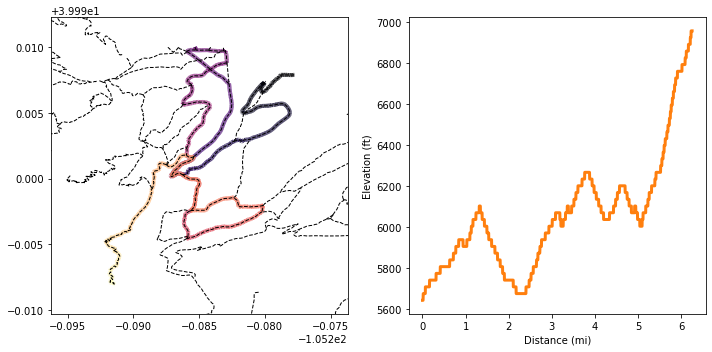

In [5]:
dist          =   6.0 * m_in_mi
# elev          = 3000.0 * m_in_ft

target_values = {'distance' : dist}


totals, test_nodes = tmap.find_route(1041, 
                               target_values, 
                               end_node=1762, reinitialize=True, reset_used_counter=True)

test_edges = tmap.edges_from_nodes(test_nodes)

route_totals = tmap.route_properties(edges=test_edges)

fig, ax = maptrails.plot_trails(tmap, edges=test_edges, show_profile=True, fs = 5)

Distance (mi)  Elev. + (ft)  Elev. - (ft) Min Elev. (ft) Max Elev. (ft) Min Grade (%) Max Grade (%)  Repeated (%)
        13.14          3760          3143          5643          6955        -56.88          0.00         33.70


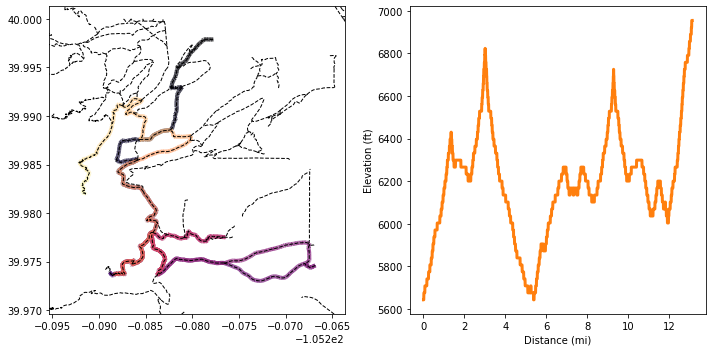

In [6]:
dist          =   12.0 * m_in_mi
# elev          = 3000.0 * m_in_ft

target_values = {'distance' : dist}


totals, test_nodes = tmap.find_route(1041, 
                               target_values, 
                               end_node=1762, reinitialize=True, reset_used_counter=True)

test_edges = tmap.edges_from_nodes(test_nodes)

route_totals = tmap.route_properties(edges=test_edges)

fig, ax = maptrails.plot_trails(tmap, edges=test_edges, show_profile=True, fs = 5)

## Test Case 2:

Testing out by picking a point in a known-to-be-connected area of Chautaqua and see how the algorithm performs making a route that completes a full round trip. Trying out a few constraints.

Distance (mi)  Elev. + (ft)  Elev. - (ft) Min Elev. (ft) Max Elev. (ft) Min Grade (%) Max Grade (%) Avg Grade (%)  Repeated (%)
        13.57          6173          5094          5675          7152        -67.19         67.19         67.19          9.16


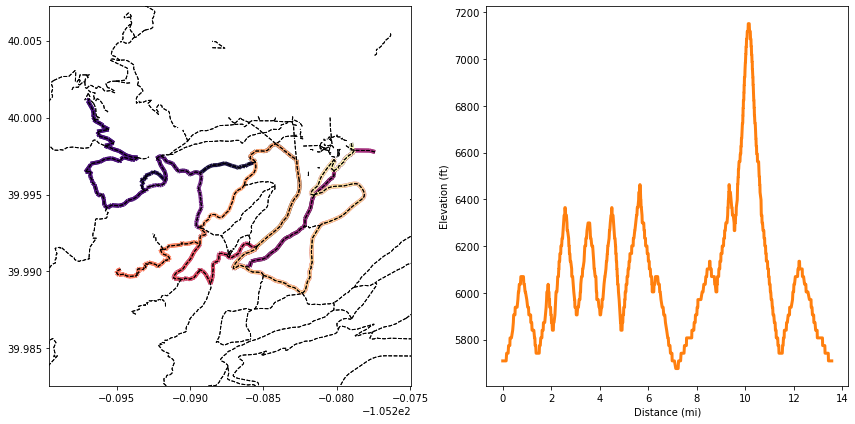

In [23]:
test_coord = (-105.27818, 39.99855) # near start of chataqua
node_index, node_id = tmap.nearest_node( test_coord[0], test_coord[1])

dist          = 13.1   * m_in_mi
elev          = 3000.0 * m_in_ft

start_node    = node_id[0]*1
end_node      = node_id[0]*1
target_values = {'distance' : dist}

totals, possible_routes =\
      tmap.find_route(start_node, 
                          target_values, 
                          end_node=end_node, reinitialize=True, reset_used_counter=True)

#tmap.write_gpx_file('test.xml',nodes=possible_routes)
fig,ax=maptrails.plot_trails(tmap, nodes=possible_routes, show_profile = True, fs = 6)
rprop = tmap.route_properties(nodes=possible_routes)


Distance (mi)  Elev. + (ft)  Elev. - (ft) Min Elev. (ft) Max Elev. (ft) Min Grade (%) Max Grade (%)  Repeated (%)
        13.58          2569          3304          5511          6430        -48.68          0.00         25.77


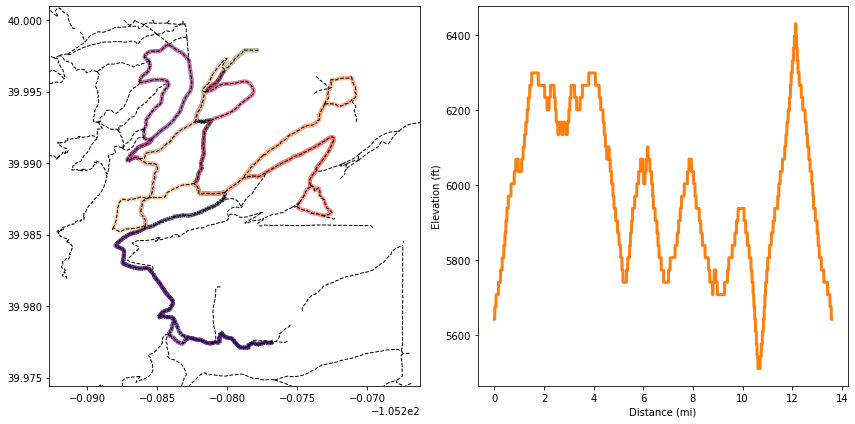

In [8]:
test_coord = (-105.27818, 39.99855) # near start of chataqua
node_index, node_id = tmap.nearest_node( test_coord[0], test_coord[1])



dist          = 13.1   * m_in_mi
elev          = 5000.0 * m_in_ft

start_node    = node_id[0]*1
end_node      = node_id[0]*1
target_values = {'distance' : dist, 'elevation_gain': elev}

totals, possible_routes =\
      tmap.find_route(start_node, 
                          target_values, 
                          end_node=end_node, reinitialize=True, reset_used_counter=True)

#tmap.write_gpx_file('test.xml',nodes=possible_routes)
fig,ax=maptrails.plot_trails(tmap, nodes=possible_routes, show_profile = True, fs = 6)
rprop = tmap.route_properties(nodes=possible_routes)


In [27]:
tmap._weight_factors

{'distance': 1,
 'elevation_gain': 1,
 'elevation_loss': 0.0,
 'elevation_change': 0.0,
 'min_grade': 0.0,
 'max_grade': 0.0,
 'average_grade': 0.0,
 'average_min_grade': 0.0,
 'average_max_grade': 0.0,
 'min_altitude': 0.0,
 'max_altitude': 0.0,
 'average_altitude': 0.0,
 'traversed_count': 10,
 'in_another_route': 2}

Distance (mi)  Elev. + (ft)  Elev. - (ft) Min Elev. (ft) Max Elev. (ft) Min Grade (%) Max Grade (%) Avg Grade (%)  Repeated (%)
        16.37          2882          4732          5544          7874        -37.63         37.63         37.63          0.00


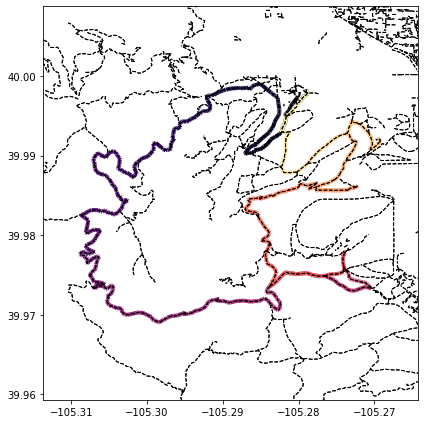

In [28]:
test_coord = (-105.27818, 39.99855) # near start of chataqua
node_index, node_id = tmap.nearest_node( test_coord[0], test_coord[1])

tmap._default_weight_factors['traversed_count'] = 100
tmap._weight_factors['traversed_count'] = 100
tmap._weight_factors['elevation_gain'] = 0
tmap._default_weight_factors['elevation_gain'] = 0

dist          = 16.1   * m_in_mi
elev          = 5000.0 * m_in_ft

start_node    = node_id[0]*1
end_node      = node_id[0]*1
target_values = {'distance' : dist, 'elevation_gain': elev}

totals, possible_routes =\
      tmap.find_route(start_node, 
                          target_values, 
                          end_node=end_node, reinitialize=True, reset_used_counter=True)

#tmap.write_gpx_file('test.xml',nodes=possible_routes)
fig,ax=maptrails.plot_trails(tmap, nodes=possible_routes, show_profile = False, fs = 6)
rprop = tmap.route_properties(nodes=possible_routes)


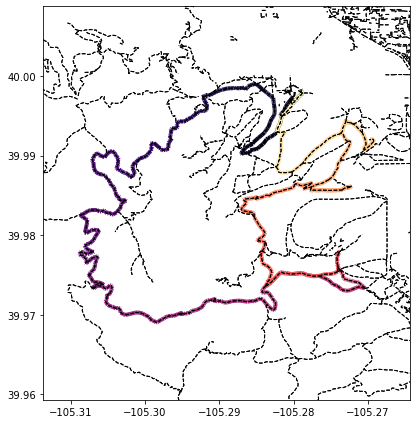

In [40]:
fig, ax = pt_temp(tmap, nodes=possible_routes, show_profile=False, fs=6, save_each_iteration=True)

In [41]:
tmap.write_gpx_file('week3test.xml',nodes=possible_routes)

Distance (mi)  Elev. + (ft)  Elev. - (ft) Min Elev. (ft) Max Elev. (ft) Min Grade (%) Max Grade (%)  Repeated (%)
        13.49          3610          3075          5511          6299        -47.43          0.00         30.11


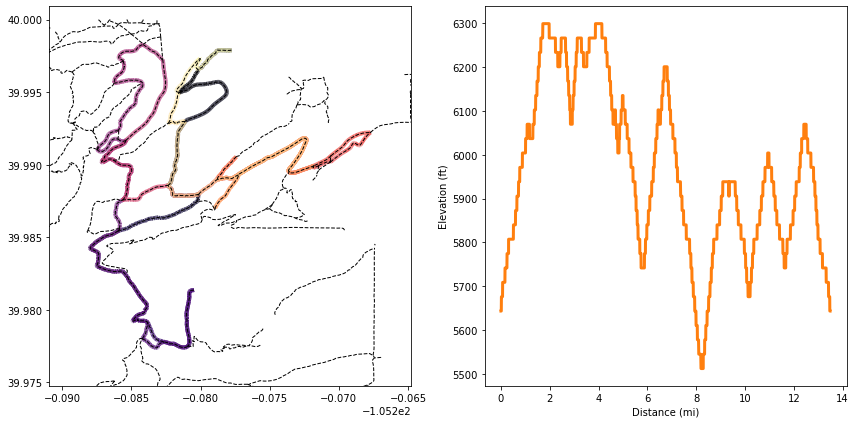

In [9]:
test_coord = (-105.27818, 39.99855) # near start of chataqua
node_index, node_id = tmap.nearest_node( test_coord[0], test_coord[1])

dist          = 13.1   * m_in_mi
elev          = 0.0 * m_in_ft

start_node    = node_id[0]*1
end_node      = node_id[0]*1
target_values = {'distance' : dist, 'elevation_gain': elev}

totals, possible_routes =\
      tmap.find_route(start_node, 
                          target_values, 
                          end_node=end_node, reinitialize=True, reset_used_counter=True)

#tmap.write_gpx_file('test.xml',nodes=possible_routes)
fig,ax=maptrails.plot_trails(tmap, nodes=possible_routes, show_profile = True, fs = 6)
rprop = tmap.route_properties(nodes=possible_routes)


Distance (mi)  Elev. + (ft)  Elev. - (ft) Min Elev. (ft) Max Elev. (ft) Min Grade (%) Max Grade (%)  Repeated (%)
        50.11         13445         13455          5643          8333        -56.88          0.00         19.19


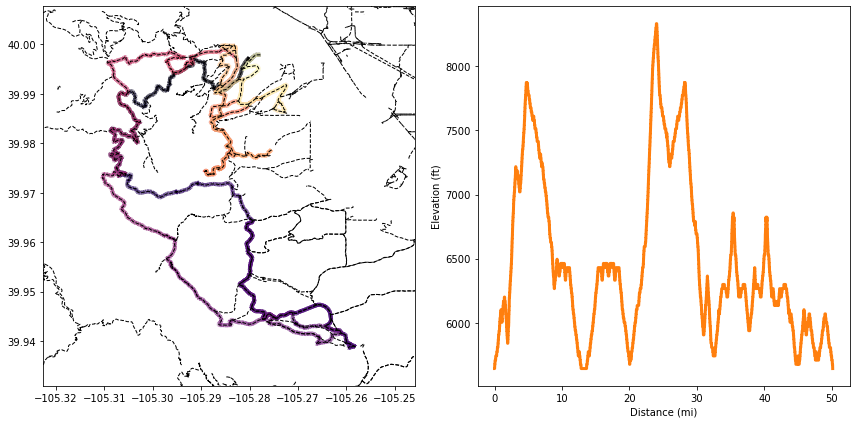

In [6]:
test_coord = (-105.27818, 39.99855) # near start of chataqua
node_index, node_id = tmap.nearest_node( test_coord[0], test_coord[1])

dist          = 20.1   * m_in_mi
elev          = 1000.0 * m_in_ft

start_node    = node_id[0]*1
end_node      = node_id[0]*1
target_values = {'distance' : dist} #, 'elevation_gain': elev}

tmap.debug = False

totals, possible_routes =\
      tmap.find_route(start_node, 
                          target_values, 
                          end_node=end_node, reinitialize=True, reset_used_counter=True)

tmap.write_gpx_file('test.xml',nodes=possible_routes, elevation=False)
fig,ax=maptrails.plot_trails(tmap, nodes=possible_routes, show_profile = True, fs = 6)
rprop = tmap.route_properties(nodes=possible_routes)


## Test 3: Multiple Route Find

In [22]:
test_coord = (-105.27818, 39.99855) # near start of chataqua
node_index, node_id = tmap.nearest_node( test_coord[0], test_coord[1])

dist          = 6.5  * m_in_mi
elev          = 0.0 * m_in_ft

start_node    = node_id[0]*1
end_node      = node_id[0]*1
target_values = {'distance' : dist} #, 'elevation_gain': elev}


print(start_node, end_node, target_values)

totals, possible_routes, scores =\
      tmap.multi_find_route(start_node, 
                            target_values,
                            n_routes = 5,                            
                            end_node=end_node, reinitialize=True, reset_used_counter=True)

#tmap.write_gpx_file('test.xml',nodes=possible_routes)
#fig,ax=maptrails.plot_trails(tmap, nodes=possible_routes, show_profile = True, fs = 6)
#rprop = tmap.route_properties(nodes=possible_routes)


1041 1041 {'distance': 10460.71}


In [19]:
output = [ tmap.route_properties(nodes=nodes, verbose=False) for nodes in possible_routes]

In [20]:
output

[{'distance': 6.5498868510129755,
  'elevation_gain': 1287.9331617848006,
  'elevation_loss': 1803.0250417848006,
  'min_grade': -48.684697908653725,
  'max_grade': 0.0,
  'max_altitude': 6430.4464,
  'min_altitude': 5511.8112,
  'repeated_percent': 0.0},
 {'distance': 6.551644155187976,
  'elevation_gain': 2260.6719983426497,
  'elevation_loss': 2014.6089983426496,
  'min_grade': -60.207799181473966,
  'max_grade': 0.0,
  'max_altitude': 6561.68,
  'min_altitude': 5643.0448,
  'repeated_percent': 0.0},
 {'distance': 6.6292099867956695,
  'elevation_gain': 1517.5523009879744,
  'elevation_loss': 1622.5391809879743,
  'min_grade': -48.684697908653725,
  'max_grade': 0.0,
  'max_altitude': 6200.7876,
  'min_altitude': 5511.8112,
  'repeated_percent': 0.0},
 {'distance': 6.800465960870573,
  'elevation_gain': 1562.52689017673,
  'elevation_loss': 1375.51901017673,
  'min_grade': -24.217510144688717,
  'max_grade': 0.0,
  'max_altitude': 6200.7876,
  'min_altitude': 5643.0448,
  'repeated_

In [59]:
o

[{'distance': 13.544137096614506,
  'elevation_gain': 3150.1186746684916,
  'elevation_loss': 4032.664634668492,
  'min_grade': -47.42835355714505,
  'max_grade': 0.0,
  'max_altitude': 6430.4464,
  'min_altitude': 5643.0448,
  'repeated_percent': 28.31581754541716},
 {'distance': 14.690510566809799,
  'elevation_gain': 4027.6726957774795,
  'elevation_loss': 4765.861695777479,
  'min_grade': -47.42835355714505,
  'max_grade': 0.0,
  'max_altitude': 7217.848,
  'min_altitude': 5643.0448,
  'repeated_percent': 0.0},
 {'distance': 13.134384321816425,
  'elevation_gain': 3092.649279451044,
  'elevation_loss': 4847.898679451044,
  'min_grade': -47.42835355714505,
  'max_grade': 0.0,
  'max_altitude': 7217.848,
  'min_altitude': 5643.0448,
  'repeated_percent': 27.325868144228473},
 {'distance': 14.325254324554722,
  'elevation_gain': 3541.196331075888,
  'elevation_loss': 4436.865651075888,
  'min_grade': -36.507107757341096,
  'max_grade': 0.0,
  'max_altitude': 6955.3808,
  'min_altitude

In [11]:
break

SyntaxError: 'break' outside loop (<ipython-input-11-6aaf1f276005>, line 4)

In [ ]:
#
# Orphaned segments
#
orphan_list = []
for i in tmap.nodes:
    
    neighbors = [n for n in tmap.neighbors(i)]
    
    if len(neighbors) > 1:
        continue
        
    other_neighbors = [n for n in tmap.neighbors(neighbors[0])]
    
    if len(other_neighbors) > 1:
        continue
        
    if (other_neighbors[0] == i):
        if (neighbors[0],i) in orphan_list:
            continue
            
        orphan_list.append((i,neighbors[0]))
    
print("Number of Orphaned Segments: ", len(orphan_list))
print("Comprising a total distance of %.3f mi of trail "%(tmap.reduce_edge_data('distance',edges=orphan_list)*0.00062137))
#print(orphan_list)

In [ ]:
def old_plot(graph, node_order=None,
         weight='distance', zoom =True,
         region = None):
    
    #pos = nx.spring_layout(graph, weight=weight, seed = 12345)
    fig, ax = plt.subplots()
    fig.set_size_inches(8,8)
    
    
    pos = {ni : np.array([n['long'],n['lat']]) for ni,n in graph.nodes(data=True)}
    
    pc = nx.draw_networkx_nodes(graph, pos, node_size=20, ax = ax)


    #edges = [(u,v)]
    etraveled = [(u,v) for (u,v,d) in graph.edges(data=True) if d['traversed_count'] > 0]
    enottraveled = [(u,v) for (u,v,d) in graph.edges(data=True) if d['traversed_count'] == 0]

    colors = 'black'
    if not (node_order is None):
        ecolor_int = [node_order.index(e[0]) for e in etraveled]
        #colors = magma((np.array(ecolor_int)+5) / ((1.0*len(node_order)+5)))
        colors = ["C%i"%i for i in ecolor_int]
        
    temp = nx.draw_networkx_edges(graph, pos, edgelist=etraveled, width=2, edge_color=colors, ax = ax)
    temp = nx.draw_networkx_edges(graph, pos, edgelist=enottraveled, width=2, style='dashed', ax = ax)
    
    

    travelled_edges = graph.edges_from_nodes(node_order)
    travelled_edges_counter = {x : 0 for x in np.unique(travelled_edges)}
    
    edge_labels = {}
    count = 0
    for (u,v,d) in graph.edges(data=True):
        
        if not((u,v) in edge_labels.keys()):
            edge_labels[(u,v)] = ''
    
    count = 1
    for (u,v) in travelled_edges:
        try:
            edge_labels[(u,v)] = edge_labels[(u,v)] + '%i '%(count)
        except:
            edge_labels[(v,u)] = edge_labels[(v,u)] + '%i '%(count)
            
        count = count + 1

    #try:
    #    edge_labels = { (u,v) : "%i"%(d['ShapeLen']) for (u,v,d) in graph.edges(data=True)}
    #except:    
    #    edge_labels = { (u,v) : "%i"%(d['SHAPESTLength']) for (u,v,d) in graph.edges(data=True)}
    temp = nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, label_pos=0.5, ax = ax)
    
    temp = nx.draw_networkx_labels(graph, pos, labels={n:n for n,data in graph.nodes(data=True)}, font_size=17,
                            font_color = 'black')
    
    
    chataqua = (-105.2795, 39.9972)
    ax.scatter(chataqua[0], chataqua[1], color = 'black', marker = '*', s = 200)
    
    start_point = graph.nodes[node_order[0]]
    ax.scatter(chataqua[0], chataqua[1], color = 'black', marker = '*', s = 200)


    sep = 0.025
    if zoom:
        ax.set_ylim( chataqua[1] - sep, chataqua[1]+sep)
        ax.set_xlim( chataqua[0] - sep, chataqua[0]+sep)
        
    #print(pos)
    return pc,ax

In [46]:
import numpy as np
import re

def name_to_phenome_list(name, all_phenomes):
    """
    
    Does not do any error checking if there are phenomes in name
    that are NOT in the phenomes list.
    
    Parameters:
    ----------
    name :  string of your name you want to convert to a list
    all_phenomes :list of strings of all of the phenomes (sorted or unsorted)
    
    Returns:
    ---------
    outlist  :   list-i-fied version of name
    """
    

    all_phenomes = sorted(all_phenomes,key=len)[::-1] # sort longest to smallest
    
    lookup_dict = {}
    
    for p in all_phenomes:
        if p in name:
            #
            # find the start indexes where this occurs 
            # just to get the ordering right
            #
            starts = [x.start() for x in re.finditer(p,name)]

            # remoev thise from the name so we don't repeat things we don't need
            # replace with blank spaces to keep length counts consistent
            # WARNING: if '_' is a character in a phenome (idk if it is) this won't work
            #          need to pick a new character
            name = name.replace(p,'_'*len(p))
            
            for s in starts:
                lookup_dict[s] = p # assign to dict
                
    
    # now that we're done, recombine
    outlist = [lookup_dict[k] for k in np.sort(list(lookup_dict.keys()))]
    
    return outlist
        
        
            
    
    

In [47]:
all_phenomes = ['abcd', 'dfg', 'ae', 'd', 'c', 'b', 'a']


name_to_phenome_list('aabcdddfg', all_phenomes)

['a', 'abcd', 'd', 'dfg']

In [17]:
import re
indexes = [x.span[0] for x in re.finditer('sd','asdfgsd')]

TypeError: 'builtin_function_or_method' object is not subscriptable

In [20]:
# Localhost:8080/api/hikes?d=[0,10]&e=[0,5]&mg=10&b=2&c=[0,0] 

1

In [39]:
import matplotlib.pyplot as plt
import geopandas as geopd
import gpxpy
import srtm
import shapely
import networkx as nx
import numpy as np

from planit.autotrail import trailmap


from matplotlib import rc, cm
viridis = cm.get_cmap('viridis')
magma   = cm.get_cmap('magma')
plasma  = cm.get_cmap('plasma')
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm



def pt_temp(tmap,
                nodes = None, edges = None,
                ll = None, rr = None,
                fs = 6, linecolor='gradient',
                aspect=False, plot_nodes=False,
                save_each_iteration=False,
                show_profile = True, colormap = magma):
    """
    Plot all trails in trailmap in the region selected.
    """

    if (edges is None) and (not (nodes is None)):
        edges = tmap.edges_from_nodes(nodes)

    color = ['C%i'%(i) for i in range(9)]
    ci = 1

    if show_profile and (edges is None):
        show_profile = False

    if show_profile:
        fig, all_ax = plt.subplots(1,2)
        fig.set_size_inches(fs*2,fs)
    else:
        fig, all_ax = plt.subplots()
        fig.set_size_inches(fs,fs)



    if not (edges is None):
        if (ll is None) and (rr is None):

            min_long, max_long = 9999, -10000
            min_lat, max_lat = 9999, -10000

            for e in edges:
                u = e[0]
                v = e[1]
                long = [c[0] for c in tmap.edges[(u,v,trailmap._IDIR)]['geometry'].coords]
                lat  = [c[1] for c in tmap.edges[(u,v,trailmap._IDIR)]['geometry'].coords]

                min_long = np.min([min_long,np.min(long)])
                max_long = np.max([max_long,np.max(long)])
                min_lat  = np.min([min_lat,np.min(lat)])
                max_lat  = np.max([max_lat,np.max(lat)])

            dlong = (max_long-min_long)
            dlat  = (max_lat-min_lat)

            if dlong < dlat:
                d = dlat - dlong
                min_long = min_long - 0.5*d
                max_long = max_long + 0.5*d
            else:
                d = dlong - dlat
                min_lat = min_lat - 0.5*d
                max_lat = max_lat + 0.5*d

            # now expand both by 25%
            dlong = (max_long-min_long)*0.25
            dlat  = (max_lat-min_lat)*0.25
            min_long = min_long - 0.5*dlong
            max_long = max_long + 0.5*dlong
            min_lat = min_lat - 0.5*dlat
            max_lat = max_lat + 0.5*dlat

            ll = (min_long,min_lat)
            rr = (max_long,max_lat)

    if ll is None:
        ll = (-np.inf,-np.inf)
        rr = (np.inf,np.inf)

    if show_profile:
        ax = all_ax[0]
    else:
        ax = all_ax

    for (u,v,d) in tmap.edges(data=True):

        long = np.array([c[0] for c in d['geometry'].coords])
        lat  = np.array([c[1] for c in d['geometry'].coords])

        try:
            if all(long<ll[0]) or all(long>rr[0]) or all(lat<ll[1]) or all(lat>rr[1]):
                continue
        except:
            print(long)
            print(lat)
            print(ll, rr)

        ax.plot(long, lat, lw = 1, ls = '--', color = 'black')
    plt.tight_layout()
    ax.set_xlim(ll[0],rr[0])
    ax.set_ylim(ll[1],rr[1])

    if plot_nodes and (not (nodes is None)):
        node_lat = tmap.reduce_node_data('lat',function=None, nodes=nodes)
        node_long = tmap.reduce_node_data('long',function=None, nodes=nodes)
        ax.scatter(node_long, node_lat, s = 80, marker='o',color='black')

    if aspect:
        # keep aspect ratio by adjusting figure size. Normalize to longest side
        if (rr[1]-ll[1]) > (rr[0]-ll[0]):
            fsy = fs
            fsx = fs * (rr[0]-ll[0])/(rr[1]-ll[1])
        elif (rr[0]-ll[0]) > (rr[1]-ll[1]):
            fsx = fs
            fsy = fs * (rr[1]-ll[1])/(rr[0]-ll[0])
        else:
            fsx = fsy = fs

        fig.set_size_inches(fsx,fsy)

    icount = 0
    if not (edges is None):

        if linecolor == 'gradient':
            lencount = 0
            maxlen   = np.size(tmap.reduce_edge_data('distances',edges=edges,function=None))

        for e in edges:
            u,v = e[0], e[1]
            long = [c[0] for c in tmap.edges[(u,v,trailmap._IDIR)]['geometry'].coords]
            lat  = [c[1] for c in tmap.edges[(u,v,trailmap._IDIR)]['geometry'].coords]

            if u > v:
                long = long[::-1]
                lat = lat[::-1]

            if linecolor == 'gradient':
                points = np.array([long, lat]).T.reshape(-1, 1, 2)
                segments = np.concatenate([points[:-1], points[1:]], axis=1)
                norm = plt.Normalize(0.0,maxlen)
                lc = LineCollection(segments, cmap='magma', norm=norm)
                # Set the values used for colormapping
                lc.set_array(np.arange(len(long)-1)+lencount)
                lc.set_linewidth(4)
                line = ax.add_collection(lc)
                lencount=lencount+len(long)-1

                if (save_each_iteration):
                    outdir = os.getcwd() + '/movie/'
                    if not (os.path.isdir(outdir)):
                        os.mkdir(outdir)

                    fig.savefig(outdir + 'image_%08i.png'%(icount))
                    icount = icount+1

                #fig.colorbar(line, ax=axs[0])
                #ax.plot(long,lat,lw=3,ls='-',color=colormap( np.arange(long) / 1.0*np.size(long)) )
            else:
                ax.plot(long,lat,lw=3,ls='-',color=color[ci])





    if show_profile:
        ax = all_ax[1]
        dists = tmap.reduce_edge_data('distances',edges=edges,function=None) * 0.000621371
        alts  = tmap.reduce_edge_data('elevations',edges=edges,function=None) * 3.28084

        if linecolor == 'gradient' and False:
            points = np.array([np.cumsum(dists),alts]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            norm = plt.Normalize(0.0,len(dists))
            lc = LineCollection(segments, cmap='magma', norm=norm)
            # Set the values used for colormapping
            lc.set_array(np.arange(len(dists))-1)
            lc.set_linewidth(4)
            line = ax.add_collection(lc)
        else:
            ax.plot(np.cumsum(dists), alts, color = color[ci], lw = 3, ls = '-')

        ax.set_xlabel('Distance (mi)')
        ax.set_ylabel('Elevation (ft)')




    return fig, all_ax